# ROC diagnostic

In [1]:
import hypothesis
import numpy as np
import glob
import matplotlib
import pickle
import plotting
import matplotlib.pyplot as plt
import torch

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from matplotlib import rc
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_pdf_abc
from plotting import compute_2d_pdf_abc
from plotting import plot_1d_pdf
from plotting import plot_2d_pdf
from plotting import plot_1d_pdf_std
from plotting import plot_1d_contours
from plotting import plot_2d_contours
from plotting import plot_stream
from scipy import interpolate
from tqdm import tqdm
from util import load_ratio_estimator
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score

## Utilities

In [2]:
base_fpr = np.linspace(0, 1, 101)

In [3]:
def load_experiment(index):
    suffix = str(index).zfill(5)
    base = "../experiment-simulations/data/nominal/block-" + suffix
    likelihood_samples = np.load(base + "/density-contrasts-cut-noised.npy").astype(np.float32)
    nominal = np.array([np.load(base + "/masses.npy")[0]]).reshape(1, -1).astype(np.float32)
    
    return nominal, likelihood_samples

In [4]:
def load_result(architecture, marginalized=True, mil=False):
    if mil:
        query = "out/roc/4096"
    else:
        query = "out/coverage/4096"
    if marginalized:
        query += "/marginalized"
    else:
        query += "/not-marginalized"
    query += "/selu/roc-" + architecture + "-0*.pickle"
    result = {}
    result["auc"] = []
    result["tpr"] = []
    paths = glob.glob(query)
    for path in paths:
        with open(path, "rb") as fh:
            data = pickle.load(fh)
            data["auc"] = np.mean(data["auc"])
            process_tpr(data)
            data["tpr"] = np.mean(data["tpr"], axis=0).reshape(1, -1)
        result["auc"].append(data["auc"])
        result["tpr"].extend(data["tpr"])
    result["tpr"] = np.vstack(result["tpr"])
        
    return result

In [5]:
@torch.no_grad()
def reweigh_samples(marginal_samples, likelihood_samples, nominal, model, batch_size=1):
    weights = np.zeros(len(marginal_samples))
    inputs = torch.from_numpy(nominal).view(1, -1).float()
    ins = inputs.to(hypothesis.accelerator)
    inputs = ins.repeat(batch_size, 1)
    index = 0
    n = len(marginal_samples)
    with tqdm(total=n) as pbar:
        while index < n:
            if (n - index) < batch_size:
                batch_size = n - index
                inputs = ins.repeat(batch_size, 1)
            density = torch.from_numpy(marginal_samples[index:index + batch_size,:]).view(batch_size, -1).float()
            density = density.to(hypothesis.accelerator)
            weight = model.log_ratio(inputs=inputs, outputs=density).exp().view(-1).cpu().numpy()
            weights[index:index + batch_size] = weight
            index += batch_size
            pbar.update(batch_size)
    weights /= np.sum(weights)
    sampled_indices = np.random.choice(np.arange(len(weights)), size=len(likelihood_samples), replace=False, p=weights)
    reweighted_samples = []
    for index in sampled_indices:
        reweighted_samples.append(marginal_samples[index].reshape(1, -1))
    reweighted_samples = np.vstack(reweighted_samples).astype(np.float32)
    
    return reweighted_samples

In [6]:
def process_tpr(result):
    processed_tprs = []
    for f, t in zip(result["fpr"], result["tpr"]):
        t = interp(base_fpr, f, t)
        t[0] = 0
        processed_tprs.append(t)
    result["tpr"] = np.array(processed_tprs)

## Baseline

In [7]:
marginal_samples = np.load("../experiment-simulations/data/train/density-contrasts-cut-noised.npy")

In [8]:
result = {}
aucs = []
fprs = []
tprs = []
for experiment_index in range(10):
    nominal, likelihood_samples = load_experiment(experiment_index)
    for _ in range(1):
        reweighted_samples = marginal_samples[np.random.randint(0, 10000000, size=10000)].astype(np.float32)
        likelihood_samples = torch.tensor(likelihood_samples)
        reweighted_samples = torch.tensor(reweighted_samples)
        x = torch.cat([reweighted_samples, likelihood_samples], dim=0)
        n = len(likelihood_samples)
        ones = torch.ones(n).view(-1, 1)
        zeros = torch.zeros(n).view(-1, 1)
        y = torch.cat([ones, zeros], dim=0)
        x = x.numpy()
        y = y.numpy()
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True)
        classifier = MLPClassifier(hidden_layer_sizes=(128, 128,), max_iter=1000)
        classifier.fit(x_train, y_train.reshape(-1))
        y_score = classifier.predict_proba(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)
result["auc"] = aucs
result["fpr"] = fprs
result["tpr"] = tprs

baseline_result = result
process_tpr(baseline_result)

## Architectures

#### MLP

In [9]:
mlp_result = load_result("mlp")

#### MLP (1 million samples)

In [10]:
mlp_1m_result = load_result("mlp", mil=True)

#### MLP-BN

In [11]:
mlp_bn_result = load_result("mlp-bn")

#### ResNet-18

In [12]:
resnet_18_result = load_result("resnet-18")

#### ResNet-18-BN

In [13]:
resnet_18_bn_result = load_result("resnet-18-bn")

#### ResNet-50

In [14]:
resnet_50_result = load_result("resnet-50")

#### ResNet-50-BN

In [15]:
resnet_50_bn_result = load_result("resnet-50-bn")

## Plot

In [16]:
nominals = []
for experiment_index in range(10):
    nominal, _ = load_experiment(experiment_index)
    nominals.append(nominal.reshape(-1))

AUC MLP: 0.5701037224571568 ± 0.028727229160154837
AUC MLP-BN: 0.5727406485199361 ± 0.029789536253132104
AUC ResNet-18: 0.5722972211756604 ± 0.027826131584999136
AUC ResNet-18-BN: 0.5709606269137494 ± 0.02621059541766312
AUC ResNet-50: 0.5672871880668364 ± 0.027126434174318044
AUC ResNet-50-BN: 0.5713783659469043 ± 0.030107769961448518


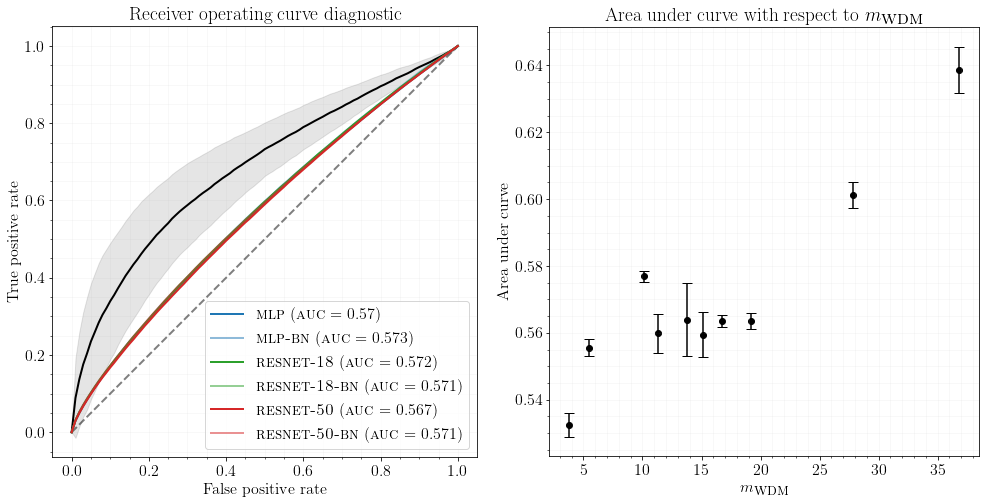

In [21]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# ROC CURVE
ax = axes[0]
make_square(ax)

# Diagonal
ax.plot([0, 1], [0, 1], color="black", linestyle='--', alpha=.5, lw=2)

# Baseline
m = np.mean(baseline_result["tpr"], axis=0)
s = np.std(baseline_result["tpr"], axis=0)
ax.plot(base_fpr, m, color="black", lw=2)
ax.fill_between(base_fpr, m - s, m + s, color="black", alpha=.1)

# MLP
m = np.mean(mlp_result["tpr"], axis=0)
s = np.std(mlp_result["tpr"], axis=0)
auc =  str(round(np.mean(mlp_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{mlp}$ (\textsc{auc} = " + auc + ')', color="C0")
print("AUC MLP:", np.mean(mlp_result["auc"]), "±", np.std(mlp_result["auc"]))

# MLP-BN
m = np.mean(mlp_bn_result["tpr"], axis=0)
s = np.std(mlp_bn_result["tpr"], axis=0)
auc =  str(round(np.mean(mlp_bn_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{mlp-bn}$ (\textsc{auc} = " + auc + ')', color="C0", alpha=.5)
print("AUC MLP-BN:", np.mean(mlp_bn_result["auc"]), "±", np.std(mlp_bn_result["auc"]))

# ResNet-18
m = np.mean(resnet_18_result["tpr"], axis=0)
s = np.std(resnet_18_result["tpr"], axis=0)
auc =  str(round(np.mean(resnet_18_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{resnet-18}$ (\textsc{auc} = " + auc + ')', color="C2")
print("AUC ResNet-18:", np.mean(resnet_18_result["auc"]), "±", np.std(resnet_18_result["auc"]))

# ResNet-18-BN
m = np.mean(resnet_18_bn_result["tpr"], axis=0)
s = np.std(resnet_18_bn_result["tpr"], axis=0)
auc =  str(round(np.mean(resnet_18_bn_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{resnet-18-bn}$ (\textsc{auc} = " + auc + ')', color="C2", alpha=.5)
print("AUC ResNet-18-BN:", np.mean(resnet_18_bn_result["auc"]), "±", np.std(resnet_18_bn_result["auc"]))

# ResNet-50
m = np.mean(resnet_50_result["tpr"], axis=0)
s = np.std(resnet_50_result["tpr"], axis=0)
auc =  str(round(np.mean(resnet_50_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{resnet-50}$ (\textsc{auc} = " + auc + ')', color="C3")
print("AUC ResNet-50:", np.mean(resnet_50_result["auc"]), "±", np.std(resnet_50_result["auc"]))

# ResNet-50
m = np.mean(resnet_50_bn_result["tpr"], axis=0)
s = np.std(resnet_50_bn_result["tpr"], axis=0)
auc =  str(round(np.mean(resnet_50_bn_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{resnet-50-bn}$ (\textsc{auc} = " + auc + ')', color="C3", alpha=.5)
print("AUC ResNet-50-BN:", np.mean(resnet_50_bn_result["auc"]), "±", np.std(resnet_50_bn_result["auc"]))

ax.minorticks_on()
ax.grid(True, which="both", alpha=.1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Receiver operating curve diagnostic")
ax.legend()


# AUC vs. m_wdm
ax = axes[1]
ax.minorticks_on()
results = []
for experimental_index in range(10):
    aucs = [
        mlp_result["auc"][experimental_index],
        mlp_bn_result["auc"][experimental_index],
        resnet_18_result["auc"][experimental_index],
        resnet_18_bn_result["auc"][experimental_index]]
        #resnet_50_result["auc"][experimental_index]]
        # resnet_50_bn_result["auc"][experimental_index]]
    results.append(aucs)
    
for index, result in enumerate(results):
    ax.scatter(nominals[index], np.mean(result), color="black")
    ax.errorbar(nominals[index], np.mean(result), np.std(result), color="black", capsize=5)
#ax.set_xlim([0, 50])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_title(r"Area under curve with respect to $m_\textsc{wdm}$")
ax.set_ylabel("Area under curve")
ax.set_xlabel(r"$m_\textsc{wdm}$")
ax.grid(True, which="both", alpha=0.1)
make_square(ax)

figure.tight_layout()
figure.savefig("plots/roc.pdf", bbox_inches="tight")
figure.show()

## Comparison against 1 million training samples

AUC MLP: 0.5701037224571568 ± 0.028727229160154837
AUC MLP (1 million): 0.6119833145408813 ± 0.023134075420525403


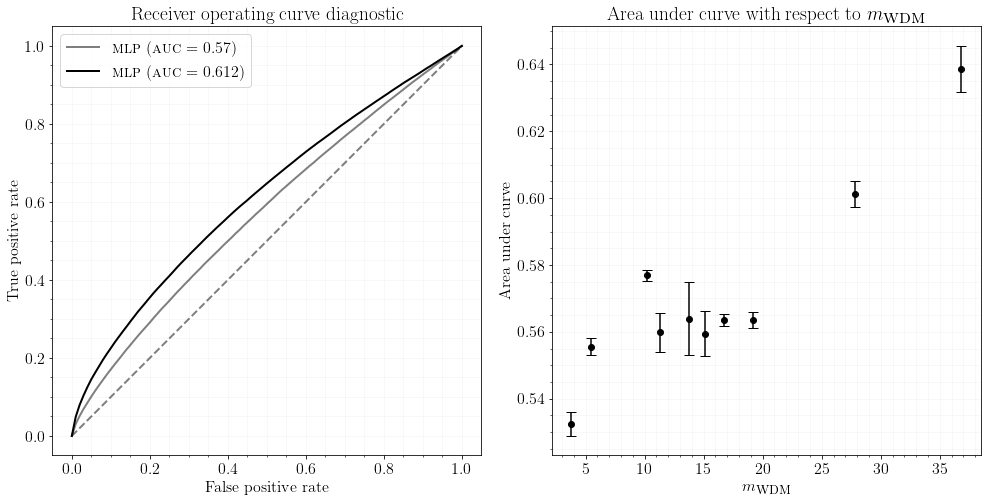

In [18]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# ROC CURVE
ax = axes[0]
make_square(ax)

# Diagonal
ax.plot([0, 1], [0, 1], color="black", linestyle='--', alpha=.5, lw=2)

# Baseline
#m = np.mean(baseline_result["tpr"], axis=0)
#s = np.std(baseline_result["tpr"], axis=0)
#ax.plot(base_fpr, m, color="black", lw=2)
#ax.fill_between(base_fpr, m - s, m + s, color="black", alpha=.1)

# MLP
m = np.mean(mlp_result["tpr"], axis=0)
s = np.std(mlp_result["tpr"], axis=0)
auc =  str(round(np.mean(mlp_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{mlp}$ (\textsc{auc} = " + auc + ')', color="black", alpha=.5)
print("AUC MLP:", np.mean(mlp_result["auc"]), "±", np.std(mlp_result["auc"]))

mlp_1m_result = load_result("mlp", mil=True)

# MLP (1 million)
m = np.mean(mlp_1m_result["tpr"], axis=0)
s = np.std(mlp_1m_result["tpr"], axis=0)
auc =  str(round(np.mean(mlp_1m_result["auc"]), 3))
ax.plot(base_fpr, m, lw=2, label=r"$\textsc{mlp}$ (\textsc{auc} = " + auc + ')', color="black")
print("AUC MLP (1 million):", np.mean(mlp_1m_result["auc"]), "±", np.std(mlp_1m_result["auc"]))

ax.minorticks_on()
ax.grid(True, which="both", alpha=.1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Receiver operating curve diagnostic")
ax.legend()


# AUC vs. m_wdm
ax = axes[1]
ax.minorticks_on()
results = []
for experimental_index in range(10):
    aucs = [
        mlp_result["auc"][experimental_index],
        mlp_bn_result["auc"][experimental_index],
        resnet_18_result["auc"][experimental_index],
        resnet_18_bn_result["auc"][experimental_index]]
        #resnet_50_result["auc"][experimental_index]]
        # resnet_50_bn_result["auc"][experimental_index]]
    results.append(aucs)
    
for index, result in enumerate(results):
    ax.scatter(nominals[index], np.mean(result), color="black")
    ax.errorbar(nominals[index], np.mean(result), np.std(result), color="black", capsize=5)
#ax.set_xlim([0, 50])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_title(r"Area under curve with respect to $m_\textsc{wdm}$")
ax.set_ylabel("Area under curve")
ax.set_xlabel(r"$m_\textsc{wdm}$")
ax.grid(True, which="both", alpha=0.1)
make_square(ax)

figure.tight_layout()
figure.savefig("plots/roc-1mil-comparison.pdf", bbox_inches="tight")
figure.show()

In [19]:
mlp_result["auc"]

[0.5787335557413764,
 0.5279991959791509,
 0.5697662338980333,
 0.636060562637551,
 0.5559465984167937,
 0.5548004861798811,
 0.5599146513752373,
 0.6035419226349009,
 0.5627064876913774,
 0.5515675300172656]

In [20]:
mlp_1m_result["auc"]

[0.6345743669005875,
 0.5688938947039519,
 0.610254692881239,
 0.653319380041159,
 0.6123745051662711,
 0.6120320305720808,
 0.5962844894553854,
 0.6367889645447482,
 0.5970915780162771,
 0.5982192431271123]